In [1]:
import torch
import dgl
from dgl.data import citation_graph as citegrh
import numpy as np


seed = 24
dgl.random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cora_dataset = citegrh.load_cora(raw_dir="./dataset/cora/")
cora_graph = cora_dataset[0]
cora_graph = cora_graph.to(device)
cora_features = cora_graph.ndata['feat']
cora_labels = cora_graph.ndata['label']
cora_train_mask = cora_graph.ndata['train_mask']
cora_val_mask = cora_graph.ndata['val_mask']
cora_test_mask = cora_graph.ndata['test_mask']

citeseer_dataset = citegrh.load_citeseer(raw_dir="./dataset/citeseer/")
citeseer_graph = citeseer_dataset[0]
citeseer_graph = citeseer_graph.to(device)
citeseer_features = citeseer_graph.ndata['feat']
citeseer_labels = citeseer_graph.ndata['label']
citeseer_train_mask = citeseer_graph.ndata['train_mask']
citeseer_val_mask = citeseer_graph.ndata['val_mask']
citeseer_test_mask = citeseer_graph.ndata['test_mask']

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from dgl.transforms import add_self_loop
from dgl.transforms import DropEdge


class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))
        nn.init.xavier_uniform_(self.weight)  # 初始化权重
        nn.init.zeros_(self.bias)  # 初始化偏置

    def forward(self, g, features, drop_edge_rate=0.0):
        
        if drop_edge_rate > 0:
            g = DropEdge(drop_edge_rate)(g)

        with g.local_scope():
            g = add_self_loop(g)
            g.ndata['h'] = features
            g.update_all(message_func=fn.copy_u('h', 'm'),
                        reduce_func=fn.sum('m', 'h'))
            h = g.ndata['h']
            h = torch.matmul(h, self.weight) + self.bias
            return h
    

class GCN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_layers, activation=F.relu, dropout=0.8, drop_edge_rate=0.0):
        super(GCN, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        self.norm = PairNorm(mode='PN-SCS', scale=1)
        self.drop_edge_rate = drop_edge_rate

        # 输入层
        self.layers.append(GraphConvolution(in_features, hidden_features))
        # 隐藏层
        for _ in range(num_layers - 2):
            self.layers.append(GraphConvolution(hidden_features, hidden_features))
        # 输出层
        self.layers.append(GraphConvolution(hidden_features, out_features))

    def forward(self, g, features):
        h = features
        for layer in self.layers[:-1]:
            h = self.norm(h)
            h = self.activation(layer(g, h, self.drop_edge_rate))
            h = self.dropout(h)
        h = self.layers[-1](g, h)
        output = F.log_softmax(h, dim=1)
        return output
    
    def evaluate(self, g, features):
        with torch.no_grad():
            h = features
            for layer in self.layers[:-1]:
                h = self.norm(h)
                h = self.activation(layer(g, h))
            h = self.layers[-1](g, h)
            output = F.log_softmax(h, dim=1)
        return output
    

class PairNorm(nn.Module):
    def __init__(self, mode='PN', scale=1):
        """
            mode:
              'None' : No normalization 
              'PN'   : Original version
              'PN-SI'  : Scale-Individually version
              'PN-SCS' : Scale-and-Center-Simultaneously version
           
            ('SCS'-mode is not in the paper but we found it works well in practice, 
              especially for GCN and GAT.)

            PairNorm is typically used after each graph convolution operation. 
        """
        assert mode in ['None', 'PN',  'PN-SI', 'PN-SCS']
        super(PairNorm, self).__init__()
        self.mode = mode
        self.scale = scale

        # Scale can be set based on origina data, and also the current feature lengths.
        # We leave the experiments to future. A good pool we used for choosing scale:
        # [0.1, 1, 10, 50, 100]

    def forward(self, x):
        if self.mode == 'None':
            return x

        col_mean = x.mean(dim=0)
        if self.mode == 'PN':
            x = x - col_mean
            rownorm_mean = (1e-6 + x.pow(2).sum(dim=1).mean()).sqrt()
            x = self.scale * x / rownorm_mean

        if self.mode == 'PN-SI':
            x = x - col_mean
            rownorm_individual = (
                1e-6 + x.pow(2).sum(dim=1, keepdim=True)).sqrt()
            x = self.scale * x / rownorm_individual

        if self.mode == 'PN-SCS':
            rownorm_individual = (
                1e-6 + x.pow(2).sum(dim=1, keepdim=True)).sqrt()
            x = self.scale * x / rownorm_individual - col_mean

        return x

In [3]:
import matplotlib.pyplot as plt


def plot_metrics(train_losses, train_metrics, val_losses, val_metrics, metric_name, save_path="metrics.png"):
    """
    根据训练集损失、训练集评价指标、验证集损失和验证集评价指标绘制图像。
    使用左右两个纵坐标轴分别显示损失和评价指标。

    参数:
    - train_losses: list - 训练集损失
    - train_metrics: list - 训练集评价指标
    - val_losses: list - 验证集损失
    - val_metrics: list - 验证集评价指标
    - metric_name: str - 评价指标的名称
    """
    epochs = range(1, len(train_losses) + 1)

    fig, ax1 = plt.subplots(figsize=(12, 8))

    # 绘制训练集和验证集的损失曲线
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.legend(loc='upper left')

    # 使用 twinx 方法创建共享 x 轴的第二个 y 轴
    ax2 = ax1.twinx()
    ax2.plot(epochs, train_metrics, 'g-', label=f'Training {metric_name}')
    ax2.plot(epochs, val_metrics, 'm-', label=f'Validation {metric_name}')
    ax2.set_ylabel(metric_name, color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend(loc='upper right')

    fig.tight_layout()
    plt.title(f'Training and Validation Loss and {metric_name}')
    plt.savefig(save_path)
    plt.show()

In [4]:
import optuna
from sklearn.metrics import accuracy_score
from torch import optim
from torch.optim.lr_scheduler import StepLR


# def objective(trial):
#     # 超参数定义
#     hidden_features = trial.suggest_int('hidden_features', 128, 512)
#     num_layers = trial.suggest_int('num_layers', 2, 16)
#     activation_name = trial.suggest_categorical(
#         'activation', ['relu', 'sigmoid', 'tanh', 'linear'])
#     lr = trial.suggest_float('lr', 1e-3, 1e-1, log=True)  # 学习率
#     epochs = trial.suggest_int('epochs', 100, 300)  # 训练 epoch
#     drop_edge_rate = trial.suggest_float('drop_edge_rate', 0, 1)  # 随机丢弃边的比例

#     activation = {
#         'relu': F.relu,
#         'sigmoid': F.tanh,
#         'tanh': F.sigmoid,
#         'linear': lambda x: x,
#     }[activation_name]

#     # 模型初始化
#     model = GCN(in_features=cora_features.shape[1],
#                 hidden_features=hidden_features,
#                 out_features=cora_labels.max().item() + 1,
#                 num_layers=num_layers,
#                 activation=activation,
#                 drop_edge_rate=drop_edge_rate).to(device)
    

#     # 定义优化器和损失函数
#     step_ratio = 0.3
#     optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-3)
#     scheduler = StepLR(optimizer, step_size=step_ratio*epochs, gamma=0.5)
#     criterion = nn.CrossEntropyLoss()

#     # 模型训练
#     for epoch in range(epochs):
#         model.train()
#         optimizer.zero_grad()
#         output = model(cora_graph, cora_features)
#         loss = criterion(output[cora_train_mask], cora_labels[cora_train_mask])
#         loss.backward()
#         optimizer.step()
#         scheduler.step()

#         # 在验证集上计算准确率
#         model.eval()
#         with torch.no_grad():
#             val_output = model(cora_graph, cora_features)
#             _, val_pred = torch.max(val_output[cora_val_mask], dim=1)
#             val_acc = accuracy_score(
#                 cora_labels[cora_val_mask].cpu(), val_pred.cpu())
            
#         trial.report(val_acc, epoch)
#         if trial.should_prune():
#             raise optuna.exceptions.TrialPruned()

#     return val_acc


# 使用Optuna进行超参数优化
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=200)

# print('最佳超参数: ', study.best_params)

In [5]:
def train_model(model, g, features, labels, train_mask, val_mask, epochs=100):


    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)
    sheduler = StepLR(optimizer, step_size=0.3*epochs, gamma=0.5)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0
    total_train_loss = []
    total_train_acc = []
    total_val_loss = []
    total_val_acc = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(g, features)
        loss = criterion(output[train_mask], labels[train_mask])
        loss.backward()
        acc = accuracy_score(labels[train_mask].cpu(), torch.max(output[train_mask], dim=1)[1].cpu())
        total_train_loss.append(loss.item())
        total_train_acc.append(acc)
        optimizer.step()
        sheduler.step()

        # 在验证集上计算损失
        model.eval()
        with torch.no_grad():
            val_output = model.evaluate(g, features)
            val_loss = criterion(val_output[val_mask], labels[val_mask])
            val_acc = accuracy_score(labels[val_mask].cpu(), torch.max(val_output[val_mask], dim=1)[1].cpu())
            total_val_loss.append(val_loss.item())
            total_val_acc.append(val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), './best_model.pth')

        print(
            f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Acc: {acc:.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}')
     
    print('最佳验证集准确率: ', best_val_acc)
    print('训练完成。')

    return total_train_loss, total_train_acc, total_val_loss, total_val_acc

Epoch 1/100, Loss: 1.9822, Acc: 0.1500, Val Loss: 1.2884, Val Acc: 0.6200
Epoch 2/100, Loss: 1.3957, Acc: 0.5786, Val Loss: 1.0520, Val Acc: 0.7520
Epoch 3/100, Loss: 0.9632, Acc: 0.8429, Val Loss: 1.0211, Val Acc: 0.7800
Epoch 4/100, Loss: 0.7160, Acc: 0.8571, Val Loss: 1.0906, Val Acc: 0.8140
Epoch 5/100, Loss: 0.5529, Acc: 0.9214, Val Loss: 1.2468, Val Acc: 0.7920
Epoch 6/100, Loss: 0.4919, Acc: 0.9071, Val Loss: 1.4378, Val Acc: 0.7780
Epoch 7/100, Loss: 0.3457, Acc: 0.9500, Val Loss: 1.6591, Val Acc: 0.7720
Epoch 8/100, Loss: 0.2658, Acc: 0.9571, Val Loss: 1.8985, Val Acc: 0.7800
Epoch 9/100, Loss: 0.2350, Acc: 0.9571, Val Loss: 2.1131, Val Acc: 0.7760
Epoch 10/100, Loss: 0.1765, Acc: 0.9714, Val Loss: 2.2081, Val Acc: 0.7780
Epoch 11/100, Loss: 0.2345, Acc: 0.9571, Val Loss: 2.2639, Val Acc: 0.7780
Epoch 12/100, Loss: 0.1136, Acc: 0.9929, Val Loss: 2.3178, Val Acc: 0.7820
Epoch 13/100, Loss: 0.1337, Acc: 0.9857, Val Loss: 2.3913, Val Acc: 0.7840
Epoch 14/100, Loss: 0.0798, Acc: 0

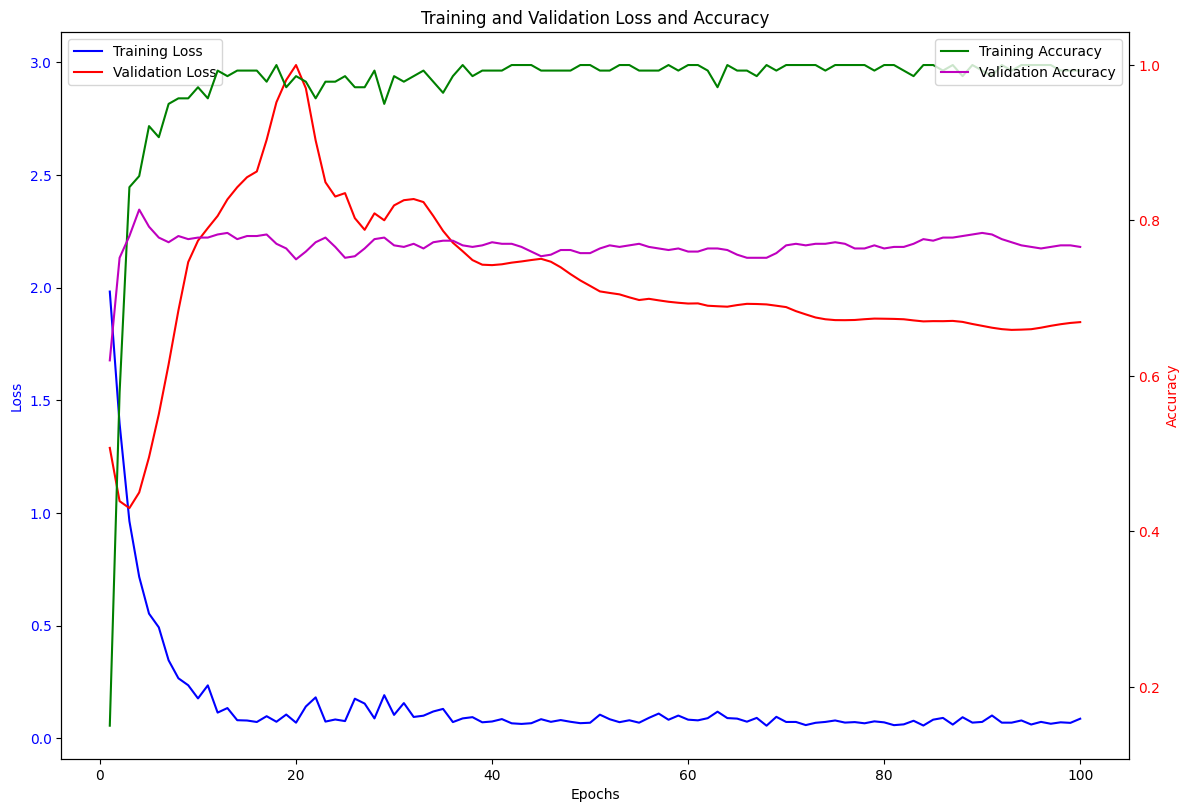

In [6]:
model = GCN(in_features=cora_features.shape[1],
            hidden_features=256,
            out_features=cora_labels.max().item() + 1,
            num_layers=2,
            activation=F.relu,
            drop_edge_rate=0.85).to(device)


total_train_loss, total_train_acc, total_val_loss, total_val_acc = train_model(
    model, cora_graph, cora_features, cora_labels, cora_train_mask, cora_val_mask, epochs=100)
plot_metrics(total_train_loss, total_train_acc, total_val_loss, total_val_acc, 'Accuracy', save_path='metrics.png')

Epoch 1/100, Loss: 1.7919, Acc: 0.1083, Val Loss: 1.3331, Val Acc: 0.5460
Epoch 2/100, Loss: 1.4935, Acc: 0.6333, Val Loss: 1.1926, Val Acc: 0.6440
Epoch 3/100, Loss: 1.1914, Acc: 0.8417, Val Loss: 1.1632, Val Acc: 0.6860
Epoch 4/100, Loss: 0.9256, Acc: 0.9083, Val Loss: 1.2153, Val Acc: 0.7000
Epoch 5/100, Loss: 0.6833, Acc: 0.9500, Val Loss: 1.3431, Val Acc: 0.7020
Epoch 6/100, Loss: 0.4742, Acc: 0.9667, Val Loss: 1.4844, Val Acc: 0.7000
Epoch 7/100, Loss: 0.3448, Acc: 0.9833, Val Loss: 1.6406, Val Acc: 0.6980
Epoch 8/100, Loss: 0.2316, Acc: 0.9917, Val Loss: 1.8259, Val Acc: 0.6940
Epoch 9/100, Loss: 0.2161, Acc: 0.9750, Val Loss: 2.0164, Val Acc: 0.6940
Epoch 10/100, Loss: 0.1430, Acc: 0.9917, Val Loss: 2.1574, Val Acc: 0.6960
Epoch 11/100, Loss: 0.0861, Acc: 1.0000, Val Loss: 2.2604, Val Acc: 0.6920
Epoch 12/100, Loss: 0.0630, Acc: 0.9917, Val Loss: 2.2819, Val Acc: 0.7040
Epoch 13/100, Loss: 0.0599, Acc: 0.9833, Val Loss: 2.2671, Val Acc: 0.6960
Epoch 14/100, Loss: 0.0693, Acc: 0

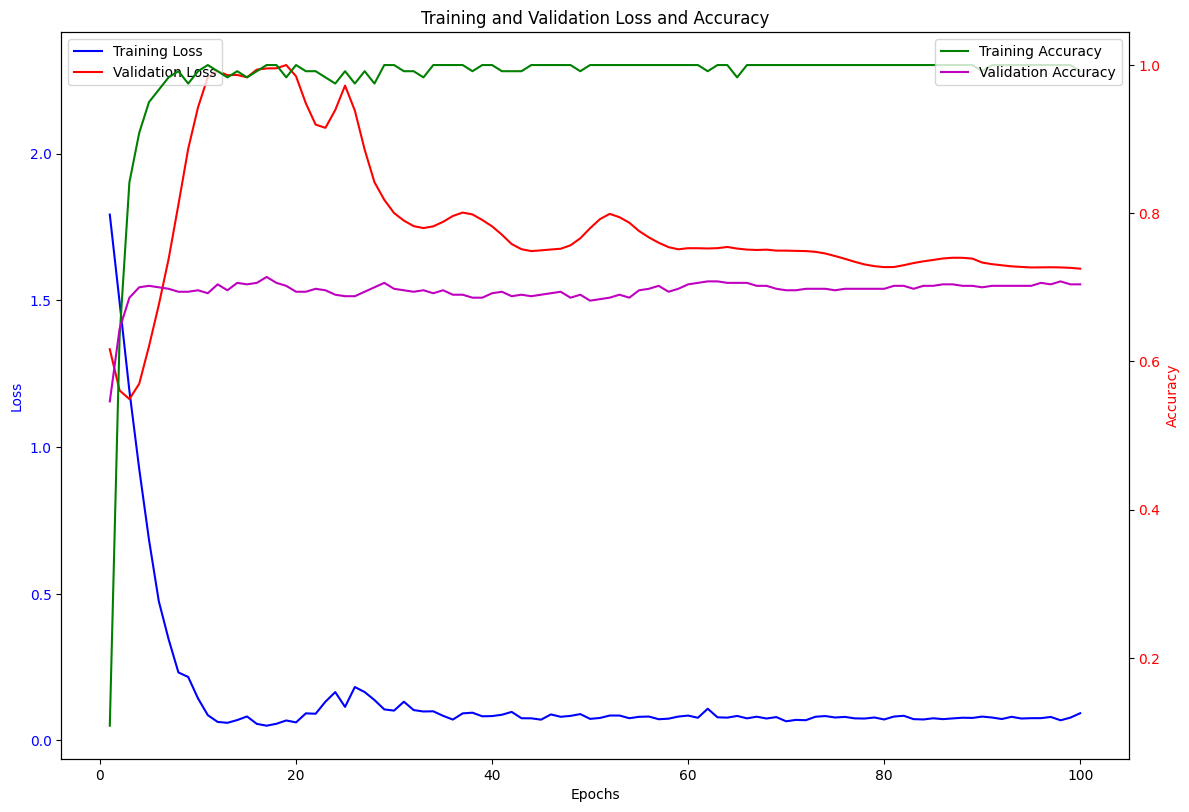

In [7]:
model = GCN(in_features=citeseer_features.shape[1],
            hidden_features=256,
            out_features=citeseer_labels.max().item() + 1,
            num_layers=2,
            activation=F.relu,
            drop_edge_rate=1).to(device)

total_train_loss, total_train_acc, total_val_loss, total_val_acc = train_model(
    model, citeseer_graph, citeseer_features, citeseer_labels, citeseer_train_mask, citeseer_val_mask, epochs=100)
plot_metrics(total_train_loss, total_train_acc, total_val_loss, total_val_acc, 'Accuracy', save_path='metrics.png')

In [8]:
import dgl
from dgl.data import citation_graph as citegrh
import torch
import numpy as np
import scipy.sparse as sp


seed = 24
dgl.random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
def load_cora_dataset(train_ratio, val_ratio):
    cora_dataset = citegrh.load_cora(raw_dir="./dataset/cora/")

    cora_graph = cora_dataset[0].to(device)
    cora_features = cora_graph.ndata['feat']

    u, v = cora_graph.edges()
    eids = np.arange(cora_graph.number_of_edges())
    eids = np.random.permutation(eids)  # 将顺序打乱

    train_size = int(cora_graph.number_of_edges() * train_ratio)
    val_size = int(cora_graph.number_of_edges() * val_ratio)
    test_size = cora_graph.number_of_edges() - train_size - val_size
    test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
    val_pos_u, val_pos_v = u[eids[test_size:test_size+val_size]
                            ], v[eids[test_size:test_size+val_size]]
    train_pos_u, train_pos_v = u[eids[test_size+val_size:]
                                ], v[eids[test_size+val_size:]]

    adj = sp.coo_matrix((np.ones(len(u)), (u.cpu().numpy(), v.cpu().numpy())))
    adj_neg = 1 - adj.todense() - np.eye(cora_graph.number_of_nodes())
    neg_u, neg_v = np.where(adj_neg != 0)

    neg_eids = np.random.choice(len(neg_u), cora_graph.number_of_edges())
    test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]
                                ], neg_v[neg_eids[:test_size]]
    val_neg_u, val_neg_v = neg_u[neg_eids[test_size:test_size+val_size]
                                ], neg_v[neg_eids[test_size:test_size+val_size]]
    train_neg_u, train_neg_v = neg_u[neg_eids[test_size+val_size:]
                                    ], neg_v[neg_eids[test_size+val_size:]]

    train_pos_g = dgl.graph((train_pos_u, train_pos_v),
                            num_nodes=cora_graph.number_of_nodes()).to(device)
    train_neg_g = dgl.graph((train_neg_u, train_neg_v),
                            num_nodes=cora_graph.number_of_nodes()).to(device)
    val_pos_g = dgl.graph((val_pos_u, val_pos_v),
                          num_nodes=cora_graph.number_of_nodes()).to(device)
    val_neg_g = dgl.graph((val_neg_u, val_neg_v),
                          num_nodes=cora_graph.number_of_nodes()).to(device)
    test_pos_g = dgl.graph((test_pos_u, test_pos_v),
                           num_nodes=cora_graph.number_of_nodes()).to(device)
    test_neg_g = dgl.graph((test_neg_u, test_neg_v),
                           num_nodes=cora_graph.number_of_nodes()).to(device)
    
    return cora_graph, cora_features, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g


def load_citeseer_dataset(train_ratio, val_ratio):
    citeseer_dataset = citegrh.load_citeseer(raw_dir="./dataset/citeseer/")

    citeseer_graph = citeseer_dataset[0].to(device)
    citeseer_features = citeseer_graph.ndata['feat']

    u, v = citeseer_graph.edges()
    eids = np.arange(citeseer_graph.number_of_edges())
    eids = np.random.permutation(eids)  # 将顺序打乱

    train_size = int(citeseer_graph.number_of_edges() * train_ratio)
    val_size = int(citeseer_graph.number_of_edges() * val_ratio)
    test_size = citeseer_graph.number_of_edges() - train_size - val_size
    test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
    val_pos_u, val_pos_v = u[eids[test_size:test_size+val_size]
                            ], v[eids[test_size:test_size+val_size]]
    train_pos_u, train_pos_v = u[eids[test_size+val_size:]
                                ], v[eids[test_size+val_size:]]

    adj = sp.coo_matrix((np.ones(len(u)), (u.cpu().numpy(), v.cpu().numpy())))
    adj_neg = 1 - adj.todense() - np.eye(citeseer_graph.number_of_nodes())
    neg_u, neg_v = np.where(adj_neg != 0)

    neg_eids = np.random.choice(len(neg_u), citeseer_graph.number_of_edges())
    test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]
                                ], neg_v[neg_eids[:test_size]]
    val_neg_u, val_neg_v = neg_u[neg_eids[test_size:test_size+val_size]
                                ], neg_v[neg_eids[test_size:test_size+val_size]]
    train_neg_u, train_neg_v = neg_u[neg_eids[test_size+val_size:]
                                    ], neg_v[neg_eids[test_size+val_size:]]

    train_pos_g = dgl.graph((train_pos_u, train_pos_v),
                            num_nodes=citeseer_graph.number_of_nodes()).to(device)
    train_neg_g = dgl.graph((train_neg_u, train_neg_v),
                            num_nodes=citeseer_graph.number_of_nodes()).to(device)
    val_pos_g = dgl.graph((val_pos_u, val_pos_v),
                            num_nodes=citeseer_graph.number_of_nodes()).to(device)
    val_neg_g = dgl.graph((val_neg_u, val_neg_v),
                            num_nodes=citeseer_graph.number_of_nodes()).to(device)
    test_pos_g = dgl.graph((test_pos_u, test_pos_v),
                            num_nodes=citeseer_graph.number_of_nodes()).to(device)
    test_neg_g = dgl.graph((test_neg_u, test_neg_v),
                            num_nodes=citeseer_graph.number_of_nodes()).to(device)
    
    return citeseer_graph, citeseer_features, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g

In [10]:
import torch.nn as nn
from dgl.transforms import add_self_loop
from dgl.transforms import DropEdge
import torch.nn.functional as F
import dgl.function as fn
from sklearn.metrics import roc_auc_score


class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))
        nn.init.xavier_uniform_(self.weight)  # 初始化权重
        nn.init.zeros_(self.bias)  # 初始化偏置

    def forward(self, g, features, drop_edge_rate=0.0):

        if drop_edge_rate > 0:
            g = DropEdge(drop_edge_rate)(g)

        with g.local_scope():
            g = add_self_loop(g)
            g.ndata['h'] = features
            g.update_all(message_func=fn.copy_u('h', 'm'),
                         reduce_func=fn.sum('m', 'h'))
            h = g.ndata['h']
            h = torch.matmul(h, self.weight) + self.bias
            return h


class GCN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_layers, activation=F.relu, dropout=0.8, drop_edge_rate=0.0):
        super(GCN, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        self.norm = PairNorm(mode='PN-SCS', scale=1)
        self.drop_edge_rate = drop_edge_rate

        # 输入层
        self.layers.append(GraphConvolution(in_features, hidden_features))
        # 隐藏层
        for _ in range(num_layers - 2):
            self.layers.append(GraphConvolution(
                hidden_features, hidden_features))
        # 输出层
        self.layers.append(GraphConvolution(hidden_features, out_features))

    def forward(self, g, features):
        h = features
        for layer in self.layers[:-1]:
            h = self.norm(h)
            h = self.activation(layer(g, h, self.drop_edge_rate))
            h = self.dropout(h)
        h = self.layers[-1](g, h)
        return h

    def evaluate(self, g, features):
        with torch.no_grad():
            h = features
            for layer in self.layers[:-1]:
                h = self.norm(h)
                h = self.activation(layer(g, h))
            h = self.layers[-1](g, h)
        return h


class PairNorm(nn.Module):
    def __init__(self, mode='PN', scale=1):
        """
            mode:
              'None' : No normalization 
              'PN'   : Original version
              'PN-SI'  : Scale-Individually version
              'PN-SCS' : Scale-and-Center-Simultaneously version
           
            ('SCS'-mode is not in the paper but we found it works well in practice, 
              especially for GCN and GAT.)

            PairNorm is typically used after each graph convolution operation. 
        """
        assert mode in ['None', 'PN',  'PN-SI', 'PN-SCS']
        super(PairNorm, self).__init__()
        self.mode = mode
        self.scale = scale

        # Scale can be set based on origina data, and also the current feature lengths.
        # We leave the experiments to future. A good pool we used for choosing scale:
        # [0.1, 1, 10, 50, 100]

    def forward(self, x):
        if self.mode == 'None':
            return x

        col_mean = x.mean(dim=0)
        if self.mode == 'PN':
            x = x - col_mean
            rownorm_mean = (1e-6 + x.pow(2).sum(dim=1).mean()).sqrt()
            x = self.scale * x / rownorm_mean

        if self.mode == 'PN-SI':
            x = x - col_mean
            rownorm_individual = (
                1e-6 + x.pow(2).sum(dim=1, keepdim=True)).sqrt()
            x = self.scale * x / rownorm_individual

        if self.mode == 'PN-SCS':
            rownorm_individual = (
                1e-6 + x.pow(2).sum(dim=1, keepdim=True)).sqrt()
            x = self.scale * x / rownorm_individual - col_mean

        return x
    

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))

            return g.edata['score'][:, 0]
        

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).to(device)
    labels = torch.cat([torch.ones(pos_score.shape[0]),
                       torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)


def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).cpu().detach().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).cpu().detach().numpy()
    return roc_auc_score(labels, scores)

In [11]:
from torch import optim
import itertools
from torch.optim.lr_scheduler import StepLR


def train_model(model, g, features, train_pos_g, train_neg_g, val_pos_g, val_neg_g, pred, epochs=500):

    optimizer = optim.Adam(itertools.chain(
        model.parameters(), pred.parameters()), lr=0.01)
    scheduler = StepLR(optimizer, step_size=0.3*epochs, gamma=0.5)

    best_auc = 0
    total_train_loss = []
    total_train_auc = []
    total_val_loss = []
    total_val_auc = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        h = model(g, features)
        pos_score = pred(train_pos_g, h)
        neg_score = pred(train_neg_g, h)
        loss = compute_loss(pos_score, neg_score)
        acc = compute_auc(pos_score, neg_score)
        total_train_loss.append(loss.item())
        total_train_auc.append(acc)

        loss.backward()
        optimizer.step()
        scheduler.step()

        
        with torch.no_grad():
            val_pos_score = pred(val_pos_g, h)
            val_neg_score = pred(val_neg_g, h)
            val_loss = compute_loss(val_pos_score, val_neg_score)
            val_auc = compute_auc(val_pos_score, val_neg_score)
            total_val_loss.append(val_loss.item())
            total_val_auc.append(val_auc)
            if val_auc > best_auc:
                best_auc = val_auc
                torch.save(model.state_dict(), './best_model.pth')
        if epoch % 5 == 0:
            print(
                f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Acc: {acc:.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_auc:.4f}')

    print('最佳验证集AUC: ', best_auc)
    print('训练完成。')

    return total_train_loss, total_train_auc, total_val_loss, total_val_auc

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 1/500, Loss: 1.4955, Acc: 0.9137, Val Loss: 1.4526, Val Acc: 0.9149
Epoch 6/500, Loss: 0.6717, Acc: 0.7492, Val Loss: 0.6697, Val Acc: 0.7669
Epoch 11/500, Loss: 0.6679, Acc: 0.6323, Val Loss: 0.6668, Val Acc: 0.6385
Epoch 16/500, Loss: 0.6693, Acc: 0.6445, Val Loss: 0.6699, Val Acc: 0.6446
Epoch 21/500, Loss: 0.6571, Acc: 0.6898, Val Loss: 0.6514, Val Acc: 0.6995
Epoch 26/500, Loss: 0.6533, Acc: 0.6844, Val Loss: 0.6567, Val Acc: 0.6929
Epoch 31/500, Loss: 0.6308, Acc: 0.7190, Val Loss: 0.6339, Val Acc: 0.7132
Epoch 36/500, Loss: 0.6274, Acc: 0.7276, Val Loss: 0.6315, Val Acc: 0.7206
Epoch 41/500, Loss: 0.6207, Acc: 0.7254, Val Loss: 0.6184, Val Acc: 0.7213
Epoch 46/500, Loss: 0.6415, Acc: 0.7788, Val Loss: 0.6904, Val Acc: 0.7630
Epoch 51/500, Loss: 0.5871, Acc: 0.7918, Val Loss: 0.6039, Val Acc: 0.

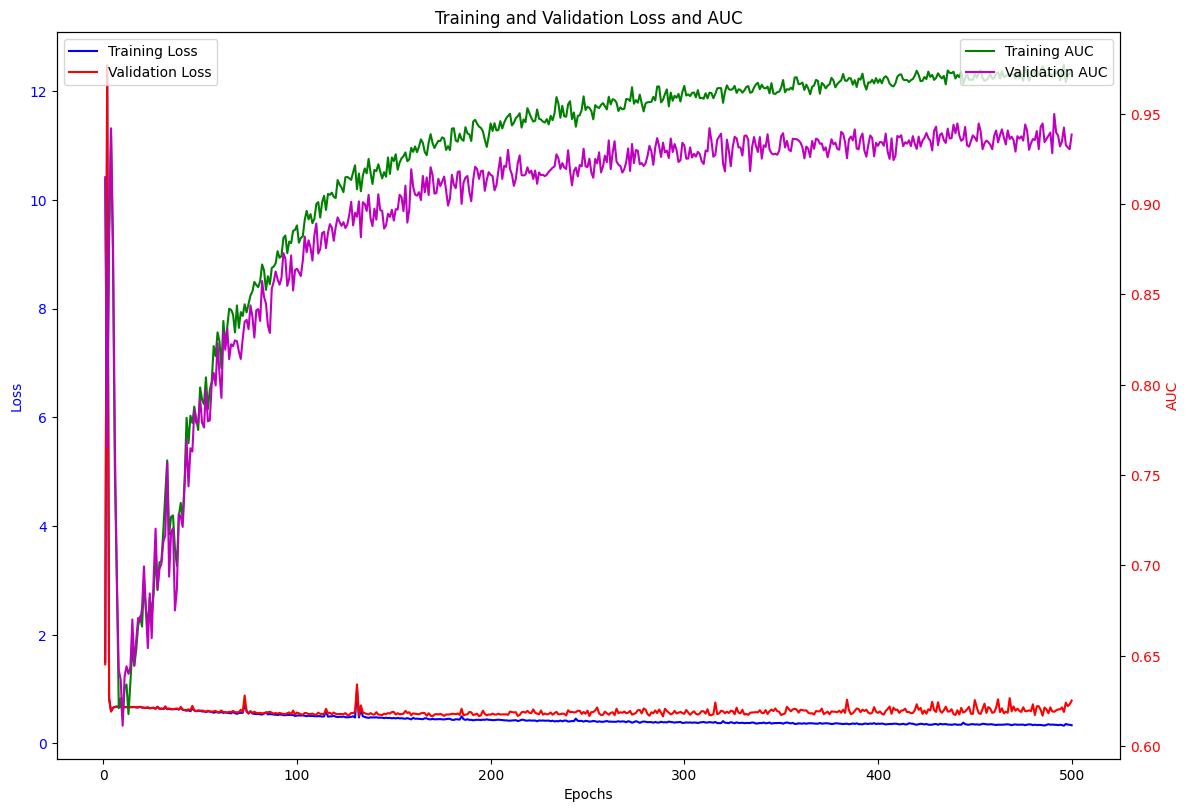

Epoch 1/500, Loss: 1.7124, Acc: 0.9059, Val Loss: 1.6802, Val Acc: 0.9025
Epoch 6/500, Loss: 0.6782, Acc: 0.7234, Val Loss: 0.6793, Val Acc: 0.7321
Epoch 11/500, Loss: 0.6852, Acc: 0.5602, Val Loss: 0.6855, Val Acc: 0.5804
Epoch 16/500, Loss: 0.6825, Acc: 0.5633, Val Loss: 0.6814, Val Acc: 0.5682
Epoch 21/500, Loss: 0.6754, Acc: 0.5701, Val Loss: 0.6776, Val Acc: 0.5684
Epoch 26/500, Loss: 0.6684, Acc: 0.5877, Val Loss: 0.6651, Val Acc: 0.6026
Epoch 31/500, Loss: 0.6636, Acc: 0.6449, Val Loss: 0.6629, Val Acc: 0.6412
Epoch 36/500, Loss: 0.6507, Acc: 0.6531, Val Loss: 0.6433, Val Acc: 0.6536
Epoch 41/500, Loss: 0.6465, Acc: 0.6498, Val Loss: 0.6509, Val Acc: 0.6312
Epoch 46/500, Loss: 0.6307, Acc: 0.6953, Val Loss: 0.6348, Val Acc: 0.6994
Epoch 51/500, Loss: 0.6302, Acc: 0.7030, Val Loss: 0.6409, Val Acc: 0.7035
Epoch 56/500, Loss: 0.6181, Acc: 0.7110, Val Loss: 0.6258, Val Acc: 0.7137
Epoch 61/500, Loss: 0.6055, Acc: 0.7441, Val Loss: 0.6206, Val Acc: 0.7576
Epoch 66/500, Loss: 0.5911,

In [12]:
cora_graph, cora_features, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g = load_cora_dataset(0.7, 0.15)

model = GCN(in_features=cora_features.shape[1],
            hidden_features=256,
            out_features=256,
            num_layers=2,
            activation=F.relu,
            drop_edge_rate=0.85).to(device)

pred = DotPredictor().to(device)

total_train_loss, total_train_auc, total_val_loss, total_val_auc = train_model(
    model, cora_graph, cora_features, train_pos_g, train_neg_g, val_pos_g, val_neg_g, pred, epochs=500)
plot_metrics(total_train_loss, total_train_auc, total_val_loss, total_val_auc, 'AUC', save_path='metrics.png')

# 在测试集上测试
final_model = GCN(in_features=cora_features.shape[1],
                    hidden_features=256,
                    out_features=256,
                    num_layers=2,
                    activation=F.relu,
                    drop_edge_rate=0.85).to(device)

total_train_loss, total_train_auc, total_val_loss, total_val_auc = train_model(
    final_model, cora_graph, cora_features, train_pos_g, train_neg_g, val_pos_g, val_neg_g, pred, epochs=500)

with torch.no_grad():
    h = final_model(cora_graph, cora_features)
    test_pos_score = pred(test_pos_g, h)
    test_neg_score = pred(test_neg_g, h)
    test_auc = compute_auc(test_pos_score, test_neg_score)
    test_loss = compute_loss(test_pos_score, test_neg_score)
    print(f"测试集AUC: {test_auc:.4f}, 测试集Loss: {test_loss:.4f}")

  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 1/500, Loss: 0.5405, Acc: 0.9672, Val Loss: 0.5477, Val Acc: 0.9617
Epoch 6/500, Loss: 0.6251, Acc: 0.7637, Val Loss: 0.6357, Val Acc: 0.7463
Epoch 11/500, Loss: 0.5872, Acc: 0.8135, Val Loss: 0.6075, Val Acc: 0.7945
Epoch 16/500, Loss: 0.5476, Acc: 0.8611, Val Loss: 0.5809, Val Acc: 0.8455
Epoch 21/500, Loss: 0.5038, Acc: 0.8984, Val Loss: 0.5317, Val Acc: 0.8804
Epoch 26/500, Loss: 0.4665, Acc: 0.9247, Val Loss: 0.5473, Val Acc: 0.8987
Epoch 31/500, Loss: 0.4530, Acc: 0.9401, Val Loss: 0.5372, Val Acc: 0.9120
Epoch 36/500, Loss: 0.4255, Acc: 0.9512, Val Loss: 0.5315, Val Acc: 0.9240
Epoch 41/500, Loss: 0.4118, Acc: 0.9539, Val Loss: 0.5398, Val Acc: 0.9138
Epoch 46/500, Loss: 0.4029, Acc: 0.9583, Val Loss: 0.5058, Val Acc: 0.9292
Epoch 51/500, Loss: 0.3865, Acc: 0.9612, Val Loss: 0.5475, Val Acc: 0.9

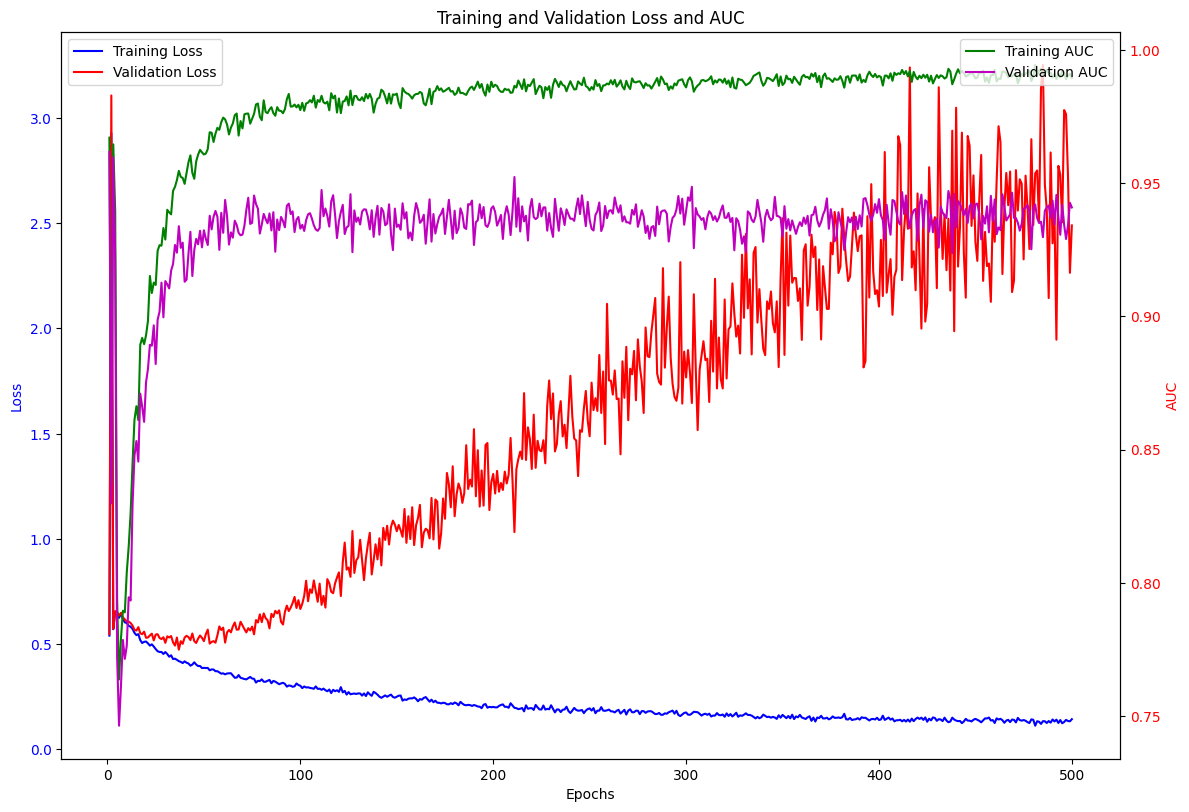

Epoch 1/500, Loss: 0.5326, Acc: 0.9730, Val Loss: 0.5431, Val Acc: 0.9661
Epoch 6/500, Loss: 0.5911, Acc: 0.8419, Val Loss: 0.6012, Val Acc: 0.8317
Epoch 11/500, Loss: 0.5285, Acc: 0.9126, Val Loss: 0.5517, Val Acc: 0.8930
Epoch 16/500, Loss: 0.4702, Acc: 0.9408, Val Loss: 0.5369, Val Acc: 0.9160
Epoch 21/500, Loss: 0.4423, Acc: 0.9467, Val Loss: 0.5184, Val Acc: 0.9191
Epoch 26/500, Loss: 0.4202, Acc: 0.9595, Val Loss: 0.4979, Val Acc: 0.9356
Epoch 31/500, Loss: 0.3927, Acc: 0.9689, Val Loss: 0.5156, Val Acc: 0.9400
Epoch 36/500, Loss: 0.3733, Acc: 0.9728, Val Loss: 0.5155, Val Acc: 0.9443
Epoch 41/500, Loss: 0.3667, Acc: 0.9706, Val Loss: 0.5608, Val Acc: 0.9293
Epoch 46/500, Loss: 0.3457, Acc: 0.9791, Val Loss: 0.5534, Val Acc: 0.9420
Epoch 51/500, Loss: 0.3431, Acc: 0.9780, Val Loss: 0.5450, Val Acc: 0.9407
Epoch 56/500, Loss: 0.3289, Acc: 0.9788, Val Loss: 0.5665, Val Acc: 0.9382
Epoch 61/500, Loss: 0.3277, Acc: 0.9790, Val Loss: 0.5396, Val Acc: 0.9432
Epoch 66/500, Loss: 0.3158,

In [13]:
citeseer_graph, citeseer_features, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g = load_citeseer_dataset(0.7, 0.15)

model = GCN(in_features=citeseer_features.shape[1],
            hidden_features=256,
            out_features=256,
            num_layers=2,
            activation=F.relu,
            drop_edge_rate=1).to(device)

pred = DotPredictor().to(device)

total_train_loss, total_train_auc, total_val_loss, total_val_auc = train_model(
    model, citeseer_graph, citeseer_features, train_pos_g, train_neg_g, val_pos_g, val_neg_g, pred, epochs=500)
plot_metrics(total_train_loss, total_train_auc, total_val_loss, total_val_auc, 'AUC', save_path='metrics.png')

# 在测试集上测试
final_model = GCN(in_features=citeseer_features.shape[1],
                    hidden_features=256,
                    out_features=256,
                    num_layers=2,
                    activation=F.relu,
                    drop_edge_rate=1).to(device)

total_train_loss, total_train_auc, total_val_loss, total_val_auc = train_model(
    final_model, citeseer_graph, citeseer_features, train_pos_g, train_neg_g, val_pos_g, val_neg_g, pred, epochs=500)

with torch.no_grad():
    h = final_model(citeseer_graph, citeseer_features)
    test_pos_score = pred(test_pos_g, h)
    test_neg_score = pred(test_neg_g, h)
    test_auc = compute_auc(test_pos_score, test_neg_score)
    test_loss = compute_loss(test_pos_score, test_neg_score)
    print(f"测试集AUC: {test_auc:.4f}, 测试集Loss: {test_loss:.4f}")

In [14]:
import numpy as np
from scipy.sparse import coo_matrix


row  = np.array([0, 3, 1, 0])
col  = np.array([1, 1, 2, 2])
data = np.array([1, 1, 1, 1])

coo = coo_matrix((data, (row, col)), shape=(4, 4))
print(coo.todense())
print(1-coo.todense()-np.eye(4))
print(np.eye(4))
negu, negv = np.where(1-coo.todense()-np.eye(4) != 0)
print(negu, negv)
neg = np.where(1-coo.todense()-np.eye(4) != 0)
print(neg)

[[0 1 1 0]
 [0 0 1 0]
 [0 0 0 0]
 [0 1 0 0]]
[[0. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[0 1 1 2 2 2 3 3] [3 0 3 0 1 3 0 2]
(array([0, 1, 1, 2, 2, 2, 3, 3], dtype=int64), array([3, 0, 3, 0, 1, 3, 0, 2], dtype=int64))


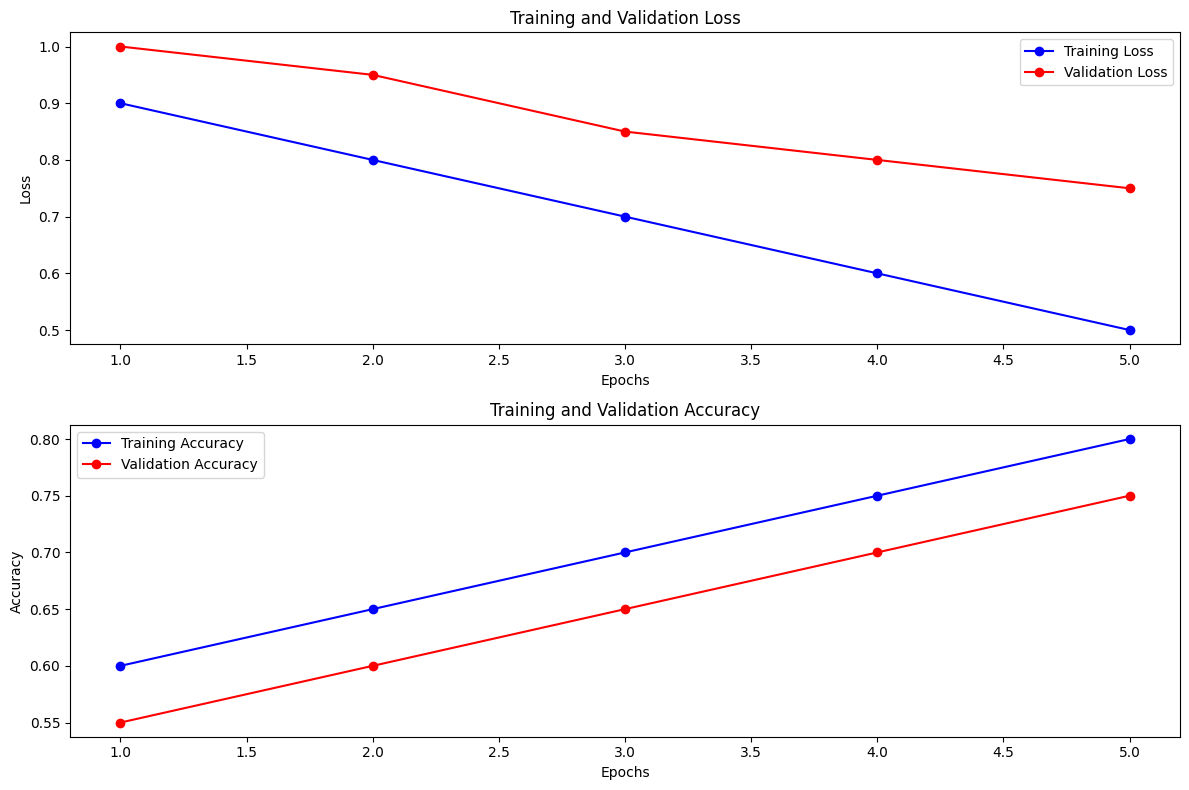

In [15]:
import matplotlib.pyplot as plt


def plot_metrics(train_losses, train_metrics, val_losses, val_metrics, metric_name):
    """
    根据训练集损失、训练集评价指标、验证集损失和验证集评价指标绘制图像。

    参数:
    - train_losses: list - 训练集损失
    - train_metrics: list - 训练集评价指标
    - val_losses: list - 验证集损失
    - val_metrics: list - 验证集评价指标
    - metric_name: str - 评价指标的名称
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 8))

    # 绘制训练集和验证集的损失曲线
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # 绘制训练集和验证集的评价指标曲线
    plt.subplot(2, 1, 2)
    plt.plot(epochs, train_metrics, 'bo-', label=f'Training {metric_name}')
    plt.plot(epochs, val_metrics, 'ro-', label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'Training and Validation {metric_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()


# 模拟数据
train_losses = [0.9, 0.8, 0.7, 0.6, 0.5]
train_metrics = [0.6, 0.65, 0.7, 0.75, 0.8]
val_losses = [1.0, 0.95, 0.85, 0.8, 0.75]
val_metrics = [0.55, 0.6, 0.65, 0.7, 0.75]
metric_name = 'Accuracy'

# 调用绘图函数
plot_metrics(train_losses, train_metrics, val_losses, val_metrics, metric_name)